<a href="https://colab.research.google.com/github/ABD-01/Siamese-Triplet/blob/master/Siamese-ORL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import glob
import numpy as np
import random
import matplotlib.pyplot as plt
from PIL import Image
from itertools import combinations 
from collections import OrderedDict
from tqdm import tqdm
 
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import torchvision
import torchvision.transforms as transforms

In [2]:
torch.cuda.is_available()

True

In [3]:
PATH = '/content/drive/MyDrive/Colab Notebooks/att_face_dataset/'

In [4]:
class CustomDataset(Dataset):

    def __init__(self, path, transform=transforms.ToTensor()):
        self.dirs = glob.glob(f'{path}*/')
        self.transform = transform
        
        self.total_images = self._get_images(self.dirs, self.transform)

    def _get_images(self, dirs, transform):
        ti = []
        for dir in tqdm(dirs):
#             images = [transform(Image.open(image)).squeeze() for image in glob.glob(f'{dir}*')]
            images = [transform(Image.open(image)) for image in glob.glob(f'{dir}*')]
            ti.append(images)
        return ti
        
    def __len__(self):
        return self.dirs.__len__()
    
    def __getitem__(self,idx):
        return torch.stack(self.total_images[idx], dim=0)
# ref : https://pytorch.org/tutorials/beginner/data_loading_tutorial.html

In [5]:
att_dataset = CustomDataset(PATH)

100%|██████████| 40/40 [03:56<00:00,  5.92s/it]


In [6]:
att_dataset[0][0].shape

torch.Size([1, 112, 92])

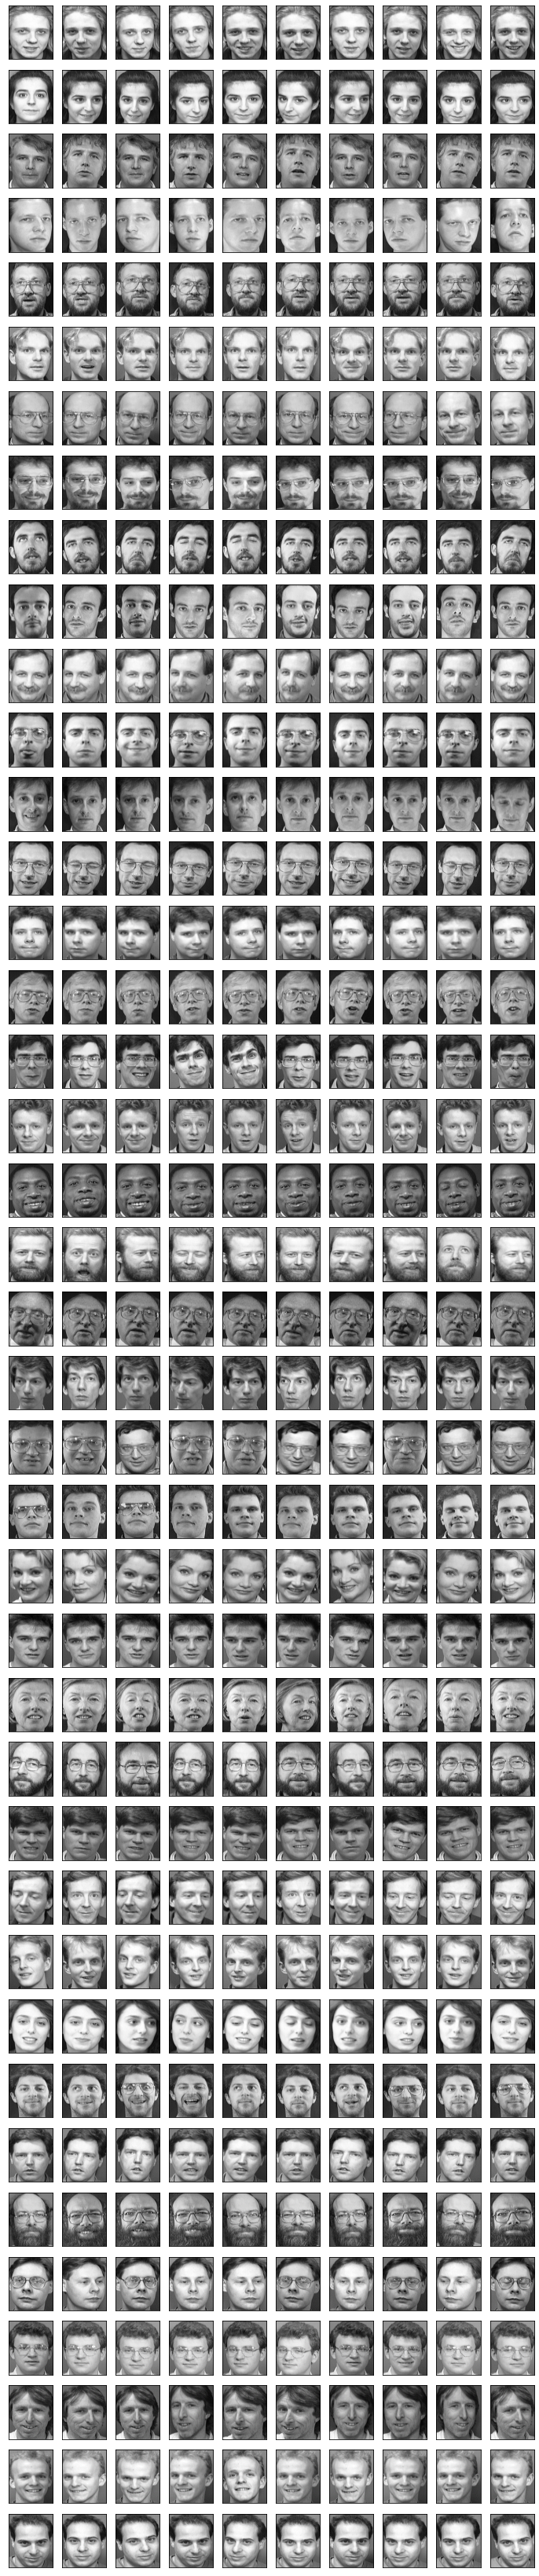

In [7]:
_,axxr = plt.subplots(40,10, figsize=(12,60))
for i in range(40):
    for j in range(10):
        axxr[i][j].imshow(att_dataset[i][j].squeeze(), cmap='gray')
plt.setp(plt.gcf().get_axes(), xticks=[], yticks=[])
# ref : https://stackoverflow.com/questions/25124143/matplotlib-subplots-get-rid-of-tick-labels-altogether
plt.show()

In [8]:
def triplet_loss(anchor, positive, negative, margin=0.2):
    pos_dist = (anchor - positive).pow(2).sum(-1) #.pow(.5)
    neg_dist = (anchor - negative).pow(2).sum(-1) #.pow(.5)
    loss = F.relu(pos_dist - neg_dist + margin)
    return loss.mean()
 
# ref: https://github.com/adambielski/siamese-triplet/blob/master/losses.py#L24

In [9]:
def get_random_triplets(embeddings,  targets=None) -> torch.Tensor:
    '''
    For each image in data (Anchor), randomly sample a Positive image from its class.  
    Then from each of the other classes sample one image (randomly) as the Negative. Hence, for every Anchor
    you will have 1 randomly selected positive from it's class and randomly selected Negative from each of the n-1 classes 
    where n is total number of classes.  For every Anchor image you would have n-1 triplets.
    So if you're having 3 classes of 10 images each then you would have 60 triplets. 
    '''


#     assert len(embeddings) == len(targets) , "Embeddings and Targets must have same lenght"

    triplets = []
    for i, embedding in enumerate(embeddings):
        temp = embeddings.pop(i)

        for anchor in embedding:
            positive = random.choice(embedding)

            for negatives in embeddings:
                negative = random.choice(negatives)

                triplets.append(torch.stack([anchor, positive, negative], dim=0))

        embeddings.insert(i, temp)

    return torch.stack(triplets, dim=0)

In [10]:
dataset = list(att_dataset)

In [37]:
train = dataset[0:30]

In [38]:
len(train)

30

In [39]:
test = dataset[30:]

In [40]:
triplets = get_random_triplets(train)

In [41]:
triplets.shape

torch.Size([8700, 3, 1, 112, 92])

In [15]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()

        self.convnet1 = nn.Sequential(OrderedDict([
                            ('conv1', nn.Conv2d(in_channels=1, out_channels=16, kernel_size=(7,5))),
                            ('conv2', nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(5,3))),
                            ('norm', nn.BatchNorm2d(32)),
                            ('actv', nn.ReLU(inplace=True)),
                            ('pool', nn.MaxPool2d(kernel_size=3, stride=2))
        ]))
        # ref : https://discuss.pytorch.org/t/is-it-possible-to-specify-a-name-for-each-layer-when-creating-the-model/33637/2

        self.convnet2 = nn.Sequential(OrderedDict([
                            ('conv1', nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3)),
                            ('conv2', nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3)),
                            ('norm', nn.BatchNorm2d(64)),
                            ('actv', nn.ReLU(inplace=True)),
                            ('pool', nn.MaxPool2d(kernel_size=3, stride=2))
        ]))

        self.convnet3 = nn.Sequential(OrderedDict([
                            ('conv1', nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3)),
                            ('conv2', nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3)),
                            ('norm', nn.BatchNorm2d(128)),
                            ('actv', nn.ReLU(inplace=True)),
                            ('pool', nn.MaxPool2d(kernel_size=3, stride=2))
        ]))
        
        self.conv     = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3)
        
        self.FCs      = nn.Sequential(OrderedDict([
                            ('FC1', nn.Linear(in_features=3072, out_features=1024)),
                            ('relu1', nn.ReLU(inplace=True)),
                            ('FC2', nn.Linear(in_features=1024, out_features=512)),
                            ('relu2', nn.ReLU(inplace=True)),
                            ('FC3', nn.Linear(in_features=512, out_features=128)),
                            ('relu3', nn.ReLU(inplace=True)),
        ]))
        

        for m in self.modules():
            classname = m.__class__.__name__
            if classname.find('Conv') != -1:
                nn.init.kaiming_normal_(m.weight.data, nonlinearity='relu')  # He-initialization
                # ref : https://pytorch.org/docs/stable/nn.init.html#torch.nn.init.kaiming_normal_

    def semi_forward(self, x):
        x = self.convnet1(x)
        x = self.convnet2(x)
        x = self.convnet3(x)
        x = self.conv(x)
        x = x.view(-1, 6*4*128)
        # x = x.reshape(-1, 10*6*128)
        x = self.FCs(x)
        return x

    def forward(self,triplet):
        anc = self.semi_forward(triplet[:,0,...])
        pos = self.semi_forward(triplet[:,1,...])
        neg = self.semi_forward(triplet[:,2,...])
        return [anc, pos, neg]

In [42]:
model = Model()
model

Model(
  (convnet1): Sequential(
    (conv1): Conv2d(1, 16, kernel_size=(7, 5), stride=(1, 1))
    (conv2): Conv2d(16, 32, kernel_size=(5, 3), stride=(1, 1))
    (norm): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (actv): ReLU(inplace=True)
    (pool): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (convnet2): Sequential(
    (conv1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (norm): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (actv): ReLU(inplace=True)
    (pool): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (convnet3): Sequential(
    (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
    (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
    (norm): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (actv): Re

In [43]:
learning_rate = 0.0001
optimizer = optim.Adam(model.parameters(), lr = learning_rate)
if torch.cuda.is_available():
    model = model.cuda()

In [ ]:
cost = []

epochs = 50
for epoch in range(epochs):

    triplets = get_random_triplets(train)
    loader = DataLoader(triplets, batch_size=100)
    for i,batch in enumerate(loader):
        if torch.cuda.is_available():
            apn = model(batch.cuda())
        else:
            apn = model(batch)

        optimizer.zero_grad()
        loss = triplet_loss(*apn)
        # loss = lossfn(*apn)
        cost.append(loss.item())

        loss.backward()
        optimizer.step()

        print(f'Epoch:[{epoch+1}/{epochs}], Step:[{i+1}/-] Cost : {loss.item()}')

Epoch:[1/50], Step:[1/-] Cost : 0.06293217092752457
Epoch:[1/50], Step:[2/-] Cost : 0.0
Epoch:[1/50], Step:[3/-] Cost : 0.04492947459220886
Epoch:[1/50], Step:[4/-] Cost : 0.017061611637473106
Epoch:[1/50], Step:[5/-] Cost : 0.2525392770767212
Epoch:[1/50], Step:[6/-] Cost : 0.12806503474712372
Epoch:[1/50], Step:[7/-] Cost : 0.009977847337722778
Epoch:[1/50], Step:[8/-] Cost : 0.0006963993655517697
Epoch:[1/50], Step:[9/-] Cost : 0.03043254464864731
Epoch:[1/50], Step:[10/-] Cost : 0.0254488755017519
Epoch:[1/50], Step:[11/-] Cost : 0.09297998994588852
Epoch:[1/50], Step:[12/-] Cost : 0.030014924705028534
Epoch:[1/50], Step:[13/-] Cost : 0.0
Epoch:[1/50], Step:[14/-] Cost : 0.0
Epoch:[1/50], Step:[15/-] Cost : 0.007459529675543308
Epoch:[1/50], Step:[16/-] Cost : 0.033487822860479355
Epoch:[1/50], Step:[17/-] Cost : 0.00786556489765644
Epoch:[1/50], Step:[18/-] Cost : 0.10372724384069443
Epoch:[1/50], Step:[19/-] Cost : 0.10350891202688217
Epoch:[1/50], Step:[20/-] Cost : 0.0277778077

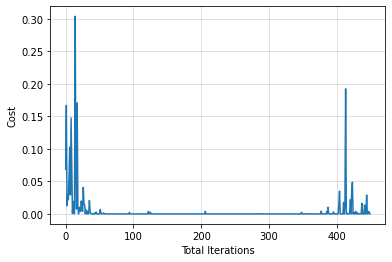

In [19]:
plt.xlabel('Total Iterations')
plt.ylabel('Cost')
plt.plot(np.arange(len(cost)), cost)
plt.grid(alpha=0.5)
plt.show()

In [ ]:
p = (apn[0] - apn[1]).pow(2).sum(-1)
n = (apn[0] - apn[2]).pow(2).sum(-1)

In [ ]:
p.max() , p.mean() , n.max(), n.mean()

(tensor(4.3036, device='cuda:0', grad_fn=<MaxBackward1>),
 tensor(1.4247, device='cuda:0', grad_fn=<MeanBackward0>),
 tensor(29.6514, device='cuda:0', grad_fn=<MaxBackward1>),
 tensor(10.6930, device='cuda:0', grad_fn=<MeanBackward0>))

In [20]:
def dist(enc1,enc2):
    return (enc1 - enc2).pow(2).sum(-1)

In [21]:
sample = torch.cat([model.semi_forward(att_dataset[i][0].unsqueeze(0).cuda()) for i in tqdm(range(40))])

100%|██████████| 10/10 [00:00<00:00, 277.91it/s]


In [22]:
sample.shape

torch.Size([10, 128])

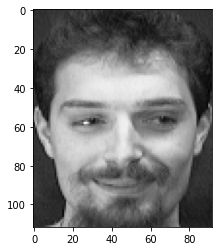

In [ ]:
Class = 7
randImg = att_dataset[Class][2]
plt.imshow(randImg.squeeze(), cmap='gray')
renc = model.semi_forward(randImg.unsqueeze(0).cuda())

In [ ]:
dis = dist(renc, sample)
dis

tensor([ 7.5347,  6.0444,  4.2683, 10.7920,  7.8644, 11.9465, 12.8775,  2.6223,
        11.1197, 14.6555], device='cuda:0', grad_fn=<SumBackward1>)

In [ ]:
dis.argmin()

tensor(7, device='cuda:0')

In [23]:
total_enc = [model.semi_forward(img.cuda()) for img in tqdm(dataset)]

100%|██████████| 10/10 [00:00<00:00, 254.17it/s]


In [24]:
total_enc[0].shape

torch.Size([10, 128])

In [25]:
pred = [torch.stack([dist(enc,sample).argmin() for enc in train_enc[i]]) for i in range(10)]
print(pred)

[tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0'), tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0'), tensor([2, 2, 5, 2, 2, 5, 2, 2, 2, 2], device='cuda:0'), tensor([3, 3, 6, 3, 3, 3, 3, 6, 6, 8], device='cuda:0'), tensor([4, 4, 8, 5, 8, 1, 4, 4, 6, 4], device='cuda:0'), tensor([5, 5, 5, 5, 2, 5, 5, 5, 5, 5], device='cuda:0'), tensor([6, 6, 6, 6, 6, 6, 6, 6, 6, 4], device='cuda:0'), tensor([7, 7, 7, 7, 7, 7, 7, 7, 7, 7], device='cuda:0'), tensor([8, 8, 8, 8, 8, 8, 8, 8, 8, 8], device='cuda:0'), tensor([9, 3, 9, 3, 9, 9, 9, 9, 3, 9], device='cuda:0')]


In [26]:
tc = 0
for i in range(10):
    corr = (pred[i] == i).sum()
    print(f'(Claas {i})', corr.item(), 'out of 10')
    tc += corr.item()
print('Total Accuracy = ', tc, '%')

(Claas 0) 10 out of 10
(Claas 1) 10 out of 10
(Claas 2) 8 out of 10
(Claas 3) 6 out of 10
(Claas 4) 5 out of 10
(Claas 5) 9 out of 10
(Claas 6) 9 out of 10
(Claas 7) 10 out of 10
(Claas 8) 10 out of 10
(Claas 9) 7 out of 10
Total Accuracy =  84 %


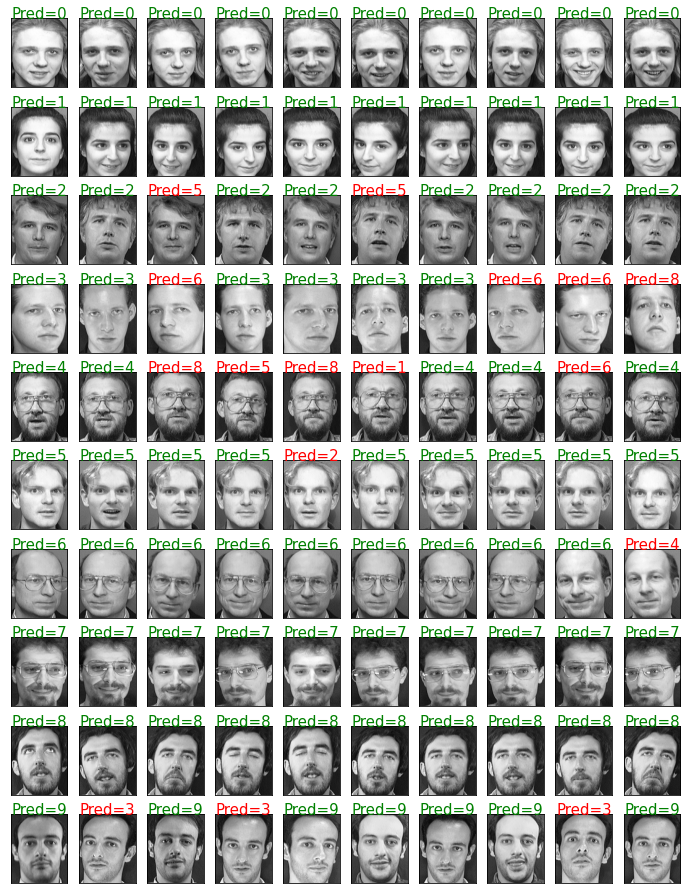

In [27]:
_,axxr = plt.subplots(10,10, figsize=(12,16))
for i in range(10):
    for j in range(10):
        axxr[i][j].imshow(att_dataset[i][j].squeeze(), cmap='gray')
        if pred[i][j] == i:
            axxr[i][j].text(0.5,1,f'Pred={i}', color='green', fontsize=15)
        else:
            axxr[i][j].text(0.5,1,f'Pred={pred[i][j].item()}', color='red', fontsize=15)
plt.setp(plt.gcf().get_axes(), xticks=[], yticks=[])
# ref : https://stackoverflow.com/questions/25124143/matplotlib-subplots-get-rid-of-tick-labels-altogether
plt.savefig('/content/drive/MyDrive/Colab Notebooks/prediction_results.png', dpi=200)
plt.show()

In [28]:
sample2 = torch.cat([model.semi_forward(att_dataset[i][0].unsqueeze(0).cuda()) for i in tqdm(range(10,20))])

100%|██████████| 10/10 [00:00<00:00, 187.43it/s]


In [29]:
sample2.shape

torch.Size([10, 128])

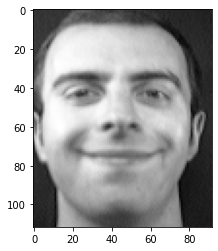

In [ ]:
Class = 11
randImg = att_dataset[Class][2]
plt.imshow(randImg.squeeze(), cmap='gray')
renc = model.semi_forward(randImg.unsqueeze(0).cuda())

In [ ]:
dis = dist(renc, sample2)
dis

tensor([ 4.3937,  0.3762,  0.7355,  1.8197, 14.1296,  1.1565,  1.2152, 13.7249,
         3.7829,  3.4998], device='cuda:0', grad_fn=<SumBackward1>)

In [ ]:
dis.argmin()

tensor(1, device='cuda:0')

In [30]:
test_enc = [model.semi_forward(img.cuda()) for img in tqdm(test)]

100%|██████████| 10/10 [00:00<00:00, 197.00it/s]


In [31]:
test_enc[0].shape

torch.Size([10, 128])

In [32]:
pred = [torch.stack([dist(enc,sample2).argmin() for enc in test_enc[i]]) for i in range(10)]
print(pred)

[tensor([0, 3, 0, 3, 5, 3, 0, 0, 0, 7], device='cuda:0'), tensor([1, 2, 2, 1, 2, 1, 2, 1, 1, 2], device='cuda:0'), tensor([6, 2, 2, 2, 2, 2, 2, 2, 2, 2], device='cuda:0'), tensor([3, 3, 3, 3, 3, 3, 3, 3, 0, 3], device='cuda:0'), tensor([4, 1, 1, 6, 6, 7, 7, 8, 0, 4], device='cuda:0'), tensor([5, 5, 5, 5, 5, 5, 5, 5, 5, 5], device='cuda:0'), tensor([6, 6, 6, 2, 6, 6, 8, 6, 6, 6], device='cuda:0'), tensor([7, 7, 7, 4, 4, 7, 8, 7, 7, 4], device='cuda:0'), tensor([8, 1, 8, 8, 8, 8, 1, 8, 8, 1], device='cuda:0'), tensor([9, 9, 3, 0, 2, 9, 0, 0, 5, 2], device='cuda:0')]


In [36]:
tc = 0
for i in range(10):
    corr = (pred[i] == i).sum()
    print(f'(Claas {i+10})', corr.item(), 'out of 10')
    tc += corr.item()
print('Total Accuracy = ', tc, '%')

(Claas 10) 5 out of 10
(Claas 11) 5 out of 10
(Claas 12) 9 out of 10
(Claas 13) 9 out of 10
(Claas 14) 2 out of 10
(Claas 15) 10 out of 10
(Claas 16) 8 out of 10
(Claas 17) 6 out of 10
(Claas 18) 7 out of 10
(Claas 19) 3 out of 10
Total Accuracy =  64 %


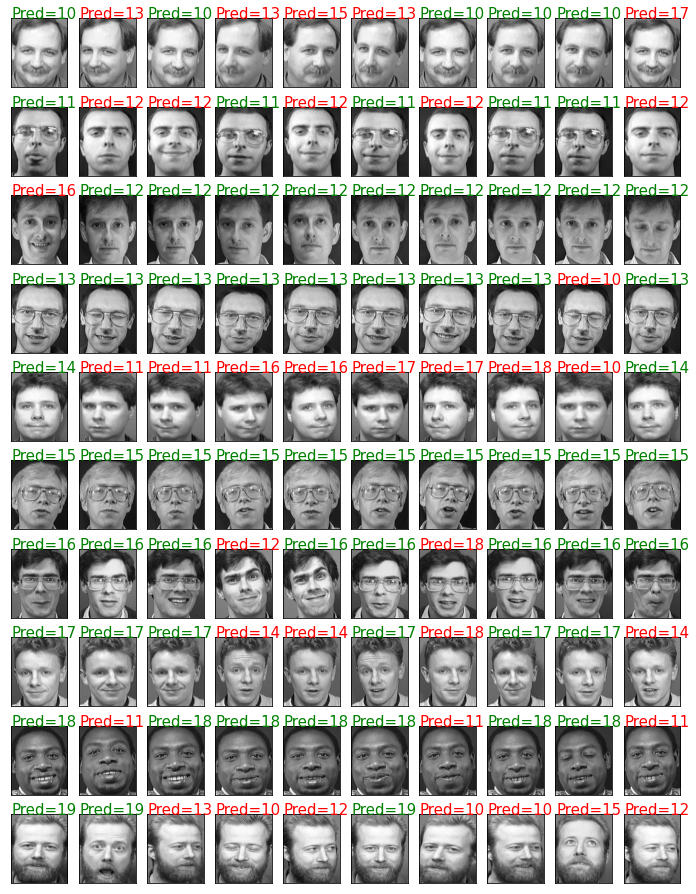

In [35]:
_,axxr = plt.subplots(10,10, figsize=(12,16))
for i in range(10):
    for j in range(10):
        axxr[i][j].imshow(att_dataset[i+10][j].squeeze(), cmap='gray')
        if pred[i][j] == i:
            axxr[i][j].text(0.5,1,f'Pred={i+10}', color='green', fontsize=15)
        else:
            axxr[i][j].text(0.5,1,f'Pred={pred[i][j].item()+10}', color='red', fontsize=15)
plt.setp(plt.gcf().get_axes(), xticks=[], yticks=[])
# ref : https://stackoverflow.com/questions/25124143/matplotlib-subplots-get-rid-of-tick-labels-altogether
plt.savefig('/content/drive/MyDrive/Colab Notebooks/prediction_results.png', dpi=200)
plt.show()